In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

For this prediction method, we use keras.sequential neural network which deals with ordering or sequencing of layers within a model. As we are dealing with 
time series data, this felt like a good choice. The four datasets that we used are a finely sampled sine curve, a
multifrequency finely sampled dataset, a poorly sampled multifrequency dataset, and realistic data from the PLAsTiCC astronomical dataset. Since my neural network requires the data shapes to be same, I interpolated the data and sampled it on a finer grid before feeding it into the neural network. Since the data is not linear, instead of using a linear interpolator, I used a cubic spline- doing this made the prediction for the 3rd dataset which is sparsely sampled multifrequency sine curve significantly better. 
I used 2-3 hidden layers depending on the dataset and got small values for mse, and my network converged. However, for the fourth dataset, I could not get my nn to converge, I tried to sample differently, but didn't get much of an improvement. The neural network doesn't learn any pattern from the data so the learning rate after trying for a few epochs, stays the same. I have tried predicting 10 next points, 3 next points or just one point. The mse doesn't show much of an improvement on any of the cases. 

In [3]:
!pip install pyarrow

  Using cached pyarrow-16.1.0-cp39-cp39-manylinux_2_28_x86_64.whl (40.8 MB)


In [4]:
##reading in time series data and evenly sampling it. Although this dataset is already finely sampled and this step isn't necessary I decided to keep it since I have it anyway


df_single = pd.read_feather("timeseries_single_frequency.feather")
index_sampled_single=[]
values_sampled_single=[]
x_dat=[]
for i in range(0,1000):
    #interpolating the sine curve
    spl = interp1d(df_single.index, df_single[df_single.columns.values[i]].values, kind='nearest')
    #evenly sampling the x axis between the min and max time value
    x_new = np.linspace(min(df_single[df_single.columns.values[i]].values),max(df_single[df_single.columns.values[i]].values), 100)
    y_new = spl(df_single.index)
    #choosing the first 40 points as input feature
    index_sampled_single.append(y_new[:40])
    #choosing the last 10 points as "labels"- this is what we are predicting
    values_sampled_single.append(y_new[-10:])
    x_dat.append(x_new)
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    index_sampled_single,values_sampled_single, test_size=0.05, random_state=0)

In [5]:
print(np.shape(index_sampled_single))

(1000, 40)


In [7]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

normalizer = layers.Normalization()
normalizer.adapt(X_train)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_root_mean_squared_error",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=0.0001,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_root_mean_squared_error",
        min_delta=1e-6,
        patience=10,
        verbose=1,
    )
]
model = keras.Sequential([
    normalizer,
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(10, activation='linear') 
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    X_train, 
    y_train,
    batch_size=128,
    epochs=200,
    validation_data=(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)),
    callbacks=callbacks
)


Epoch 1/200
8/8 [==============================] - 1s 18ms/step - loss: 1.0222 - root_mean_squared_error: 1.0110 - val_loss: 0.8167 - val_root_mean_squared_error: 0.9037 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - 0s 6ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.6947 - val_root_mean_squared_error: 0.8335 - lr: 0.0010
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 0.7041 - root_mean_squared_error: 0.8391 - val_loss: 0.6036 - val_root_mean_squared_error: 0.7769 - lr: 0.0010
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 0.6168 - root_mean_squared_error: 0.7854 - val_loss: 0.5380 - val_root_mean_squared_error: 0.7335 - lr: 0.0010
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5491 - root_mean_squared_error: 0.7410 - val_loss: 0.4840 - val_root_mean_squared_error: 0.6957 - lr: 0.0010
Epoch 6/200
8/8 [==============================] - 0s 5ms/step - loss: 0.4927 - root_mean

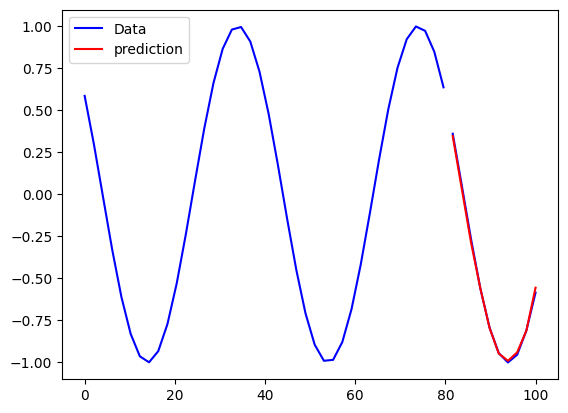

In [8]:
predictions = model.predict( tf.convert_to_tensor(X_test))

plt.plot(df_single.index[:40],X_test[0], color= 'blue', label='Data')
plt.plot(df_single.index[-10:],y_test[0], color= 'blue')
plt.plot(df_single.index[-10:],predictions[0], color= 'red', label ='prediction')
plt.legend()

In [69]:
df_single = pd.read_feather("timeseries_multiple_frequency.feather")
index_sampled_single=[]
values_sampled_single=[]

for i in range(0,1000):
    spl = interp1d(df_single.index, df_single[df_single.columns.values[i]].values, kind='cubic')
    x_new = np.linspace(min(df_single[df_single.columns.values[i]].values),max(df_single[df_single.columns.values[i]].values), 50)
    y_new = spl(df_single.index)
    index_sampled_single.append(y_new[:40])
    values_sampled_single.append(y_new[-10:])

X_train, X_test, y_train, y_test = train_test_split(
    index_sampled_single,values_sampled_single, test_size=0.05, random_state=0)



In [ ]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

normalizer = layers.Normalization()
normalizer.adapt(X_train)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_root_mean_squared_error",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta= 1e-8,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_root_mean_squared_error",
        min_delta=1e-8,
        patience=10,
        verbose=1,
    )
]
model = keras.Sequential([
    normalizer,
    layers.Dense(2, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(10, activation='linear') 
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)


history = model.fit(
    X_train, 
    y_train,
    batch_size=128,
    epochs=200,
    validation_data=(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)),
    callbacks=callbacks
)


Epoch 1/200
8/8 [==============================] - 1s 21ms/step - loss: 0.5227 - root_mean_squared_error: 0.7229 - val_loss: 0.5116 - val_root_mean_squared_error: 0.7153 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - 0s 4ms/step - loss: 0.5088 - root_mean_squared_error: 0.7133 - val_loss: 0.5045 - val_root_mean_squared_error: 0.7103 - lr: 0.0010
Epoch 3/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5028 - root_mean_squared_error: 0.7091 - val_loss: 0.5002 - val_root_mean_squared_error: 0.7072 - lr: 0.0010
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.4988 - root_mean_squared_error: 0.7063 - val_loss: 0.4970 - val_root_mean_squared_error: 0.7050 - lr: 0.0010
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 0.4954 - root_mean_squared_error: 0.7038 - val_loss: 0.4936 - val_root_mean_squared_error: 0.7026 - lr: 0.0010
Epoch 6/200
8/8 [==============================] - 0s 5ms/step - loss: 0.4920 - root_mean

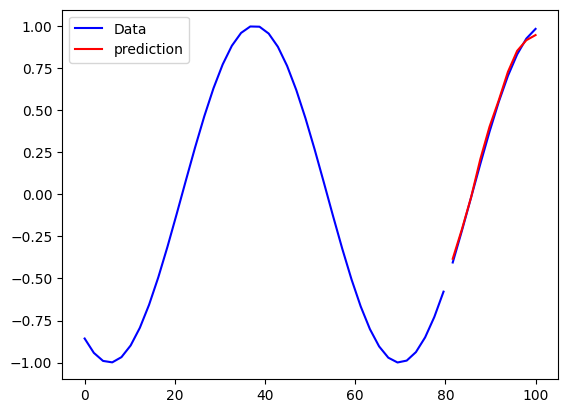

In [ ]:
predictions = model.predict( tf.convert_to_tensor(X_test))

plt.plot(df_single.index[:40],X_test[4], color= 'blue', label='Data')
plt.plot(df_single.index[-10:],y_test[4], color= 'blue')
plt.plot(df_single.index[-10:],predictions[4], color= 'red', label ='prediction')
plt.legend()

In [22]:
df_single = pd.read_feather("timeseries_multiple_frequency_sampled.feather")
index_sampled_single=[]
values_sampled_single=[]

for i in range(0,5000):
    spl = interp1d(df_single[df_single.columns.values[i]].index, df_single[df_single.columns.values[i]].values, kind='cubic')
    y_new = spl(df_single[df_single.columns.values[i]].index)
    index_sampled_single.append(y_new[:40])
    values_sampled_single.append(y_new[-10:])

X_train, X_test, y_train, y_test = train_test_split(
    index_sampled_single,values_sampled_single, test_size=0.05, random_state=0)



In [26]:
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

df_single = pd.read_feather("timeseries_multiple_frequency_sampled.feather")
index_sampled_single=[]
values_sampled_single=[]

for i in range(0,500):
    column_data = df_single.iloc[:, i]  
    clean_column_data = column_data.dropna()
    
    spl = interp1d(clean_column_data.index, clean_column_data.values, kind='cubic', fill_value="extrapolate")
    
    y_new = spl(np.linspace(np.min(clean_column_data.index),np.max(clean_column_data.index),50))

    index_sampled_single.append(y_new[:40])
    values_sampled_single.append(y_new[-10:])
    


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    index_sampled_single,values_sampled_single, test_size=0.05, random_state=0)


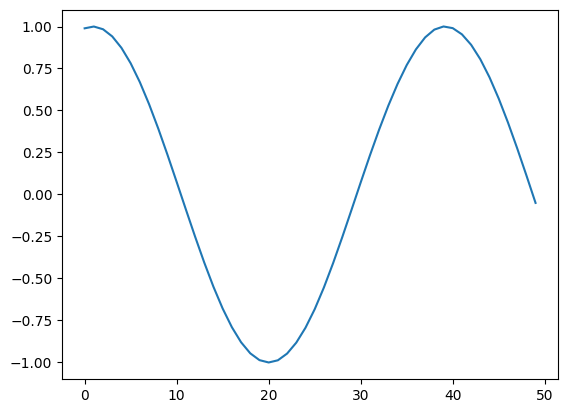

In [28]:
plt.plot(y_new)

In [33]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

normalizer = layers.Normalization()
normalizer.adapt(X_train)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_root_mean_squared_error",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta= 1e-8,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_root_mean_squared_error",
        min_delta=1e-8,
        patience=10,
        verbose=1,
    )
]
model = keras.Sequential([
    normalizer,
    layers.Dense(2, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='linear'),
    layers.Dense(10, activation='linear') 
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)


history = model.fit(
    X_train, 
    y_train,
    batch_size=128,
    epochs=500,
    validation_data=(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)),
    callbacks=callbacks
)


Epoch 1/500
4/4 [==============================] - 1s 56ms/step - loss: 0.6193 - root_mean_squared_error: 0.7869 - val_loss: 0.6787 - val_root_mean_squared_error: 0.8238 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 0.5663 - root_mean_squared_error: 0.7526 - val_loss: 0.6394 - val_root_mean_squared_error: 0.7996 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5408 - root_mean_squared_error: 0.7354 - val_loss: 0.6141 - val_root_mean_squared_error: 0.7836 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 10ms/step - loss: 0.5224 - root_mean_squared_error: 0.7227 - val_loss: 0.5915 - val_root_mean_squared_error: 0.7691 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 0.5080 - root_mean_squared_error: 0.7127 - val_loss: 0.5723 - val_root_mean_squared_error: 0.7565 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4964 - root_m

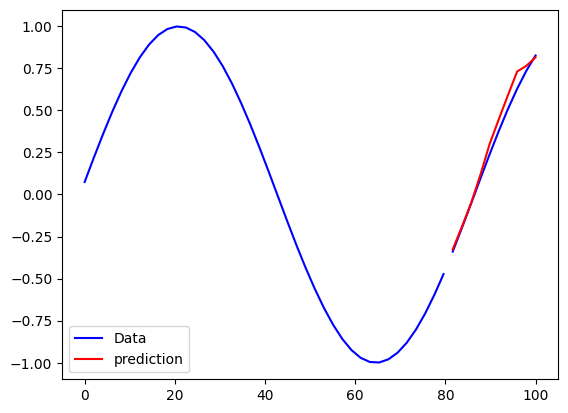

In [35]:
predictions = model.predict(tf.convert_to_tensor(X_test))

plt.plot(df_single.index[:40],X_test[4], color= 'blue', label='Data')
plt.plot(df_single.index[-10:],y_test[4], color= 'blue')
plt.plot(df_single.index[-10:],predictions[4], color= 'red', label ='prediction')
plt.legend()

In [60]:
index_sampled=[]
values_sampled=[]
x_dat=[]

plasticc_metadata = pd.read_pickle('plasticc_lightcurves_g_metadata.pkl')
with open('plasticc_lightcurves_g.pkl', 'rb') as file:
    plasticc_LC = pickle.load(file)

for i in range(0,1135):
    spl = interp1d(plasticc_LC[plasticc_metadata['object_id'].iloc[i]].index, plasticc_LC[plasticc_metadata['object_id'].iloc[i]].values, kind='cubic', fill_value= 'extrapolate')
    x_new = np.linspace(min(plasticc_LC[plasticc_metadata['object_id'].iloc[i]].index),max(plasticc_LC[plasticc_metadata['object_id'].iloc[i]].index), 50)
    y_new = spl(x_new)
    index_sampled.append(y_new[:49])
    values_sampled.append(y_new[-1:])
    x_dat.append(x_new)
X_train, X_test, y_train, y_test = train_test_split(index_sampled,values_sampled, test_size=0.05, random_state=0)



In [87]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

normalizer = layers.Normalization()
normalizer.adapt(X_train)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_root_mean_squared_error",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=0.0001,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_root_mean_squared_error",
        min_delta=1e-8,
        patience=10,
        verbose=1,
    )
]
model = keras.Sequential([
    normalizer,
    layers.Dense(2, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='relu') 
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-2),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    X_train, 
    y_train,
    batch_size=128,
    epochs=200,
    validation_data=(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)),
    callbacks=callbacks
)


Epoch 1/200
9/9 [==============================] - 0s 19ms/step - loss: 2621051.5000 - root_mean_squared_error: 1618.9662 - val_loss: 4056207.0000 - val_root_mean_squared_error: 2014.0027 - lr: 0.0100
Epoch 2/200
9/9 [==============================] - 0s 5ms/step - loss: 2621006.5000 - root_mean_squared_error: 1618.9523 - val_loss: 4056604.0000 - val_root_mean_squared_error: 2014.1013 - lr: 0.0100
Epoch 3/200
9/9 [==============================] - 0s 6ms/step - loss: 2620876.5000 - root_mean_squared_error: 1618.9121 - val_loss: 4057821.7500 - val_root_mean_squared_error: 2014.4036 - lr: 0.0100
Epoch 4/200
9/9 [==============================] - 0s 5ms/step - loss: 2620511.5000 - root_mean_squared_error: 1618.7994 - val_loss: 4060180.5000 - val_root_mean_squared_error: 2014.9890 - lr: 0.0100
Epoch 5/200
9/9 [==============================] - 0s 6ms/step - loss: 2619937.2500 - root_mean_squared_error: 1618.6221 - val_loss: 4064484.5000 - val_root_mean_squared_error: 2016.0566 - lr: 0.0100

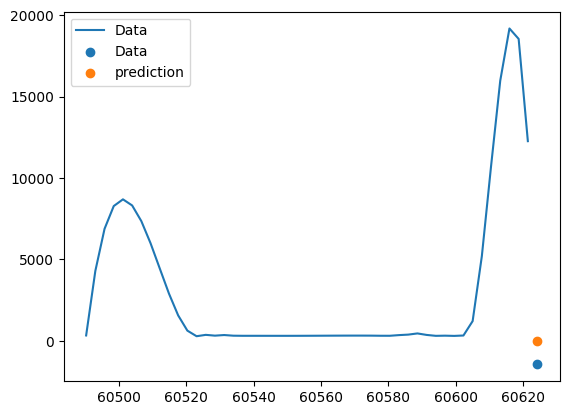

In [88]:
predictions = model.predict( tf.convert_to_tensor(y_test))

plt.plot(x_dat[2][:49], X_test[3], label='Data')
plt.scatter(x_dat[2][-1:], y_test[3], label='Data')
plt.scatter(x_dat[2][-1:],predictions[3], label ='prediction')
plt.legend()